# Dependencies

In [75]:
pacman::p_load(dplyr, ggplot2)

# Functions

In [76]:
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/color_schemes.R")

# Paths

In [77]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [78]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/"

# Main

bind all metadata

In [79]:
meta_div <- readr::read_rds(file = paste0(datapath,"capTCRseq/meta_div_goodsamples.rds"))

In [80]:
subset_meta <- meta_div[, c("Patient", "cycle", "FOLD", "Disease_type", 
"CD3", "cancergroup", "sampletype", "TRB", "Age")]

In [81]:
meta_div[ meta_div$Patient == "CHP_437", ]

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,Pass,CD3,...,observed_Shannon,estimated_Shannon,SE_Shannon,observed_Simpson,estimated_Simpson,SE_Simpson,file,basename,Group,sampletype
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
829,CHP_437_01,CHP_437,X01,0,0,9,OS,0,NA,0,...,NA,NA,NA,NA,NA,NA,NA,NA,CHP,NA
830,CHP_437_02,CHP_437,X02,0,0,9,OS,0,NA,0,...,NA,NA,NA,NA,NA,NA,NA,NA,CHP,NA
831,CHP_437_03,CHP_437,X03,0,0,9,OS,0,NA,0,...,NA,NA,NA,NA,NA,NA,NA,NA,CHP,NA
832,CHP_437_04,CHP_437,X04,0,0,9,OS,0,NA,0,...,NA,NA,NA,NA,NA,NA,NA,NA,CHP,NA
833,CHP_437_05,CHP_437,X05,0,0,9,OS,0,NA,0,...,NA,NA,NA,NA,NA,NA,NA,NA,CHP,NA


In [82]:
# recode cycle to numeric
subset_meta$cycle <- gsub("X", "", subset_meta$cycle)

In [83]:
subset_meta$cycle <- as.numeric(subset_meta$cycle)

In [84]:
table(subset_meta$sampletype, useNA = "ifany")


 PBMC Tumor cfDNA  <NA> 
  258    18   278   256 

In [85]:
#remove Tumor samples
subset_meta <- subset_meta[ !subset_meta$sampletype %in% c("Tumor"),]
#remove Normal samples
subset_meta <- subset_meta[ which(subset_meta$cancergroup != "Normal"),]
# remove LFS samples
subset_meta <- subset_meta[which(subset_meta$cancergroup != "LFS"),]

In [86]:
table(subset_meta$sampletype, useNA = "ifany")


 PBMC cfDNA  <NA> 
  234   278   256 

In [87]:
# NAs are flow
subset_meta$sampletype[ is.na(subset_meta$sampletype) ] <- "Flow"

In [88]:
mydat <- matrix(ncol = 20, nrow = length(unique(subset_meta$Patient)))
rownames(mydat) <- unique(subset_meta$Patient)
# assign colnames 5 PBMCs, 5 cfDNA, 5 FOLD,  5 CD3 separate by _
colnames(mydat) <- c(paste0(rep("PBMC_", 5), 1:5),
                        paste0(rep("cfDNA_", 5), 1:5),
                        paste0(rep("FOLD_", 5), 1:5),
                        paste0(rep("CD3_", 5), 1:5))

In [89]:
datatype.fx <- function(x){

x$datatype <- NA
for(i in 1:nrow(x)){
#if is.na(TRB) & !is.na(FOLD) & !is.na(CD3), then datatype = FOLD,CD3
    if(is.na(x$TRB[i]) & !is.na(x$FOLD[i]) & !is.na(x$CD3[i])){
        x$datatype[i] <- paste0("FOLD", "_",x$cycle[i], ",", "CD3","_", x$cycle[i])
    }
#if is.na(TRB) & !is.na(CD3) & is.na(FOLD), then datatype = CD3
    if(is.na(x$TRB[i]) & !is.na(x$CD3[i]) & is.na(x$FOLD[i])){
        x$datatype[i] <- paste0("CD3","_", x$cycle[i])
    }
#if is.na(TRB) & is.na(CD3) & !is.na(FOLD), then datatype = FOLD
    if(is.na(x$TRB[i]) & !is.na(x$FOLD[i]) & is.na(x$CD3[i])){
        x$datatype[i] <- paste0("FOLD","_", x$cycle[i])
    }
#if !is.na(TRB) & !is.na(CD3) & is.na(FOLD) & sampletype == "PBMC", then datatype = PBMC, CD3
    if(!is.na(x$TRB[i]) & !is.na(x$CD3[i]) & is.na(x$FOLD[i]) & x$sampletype[i] == "PBMC"){
        x$datatype[i] <- paste0("PBMC","_", x$cycle[i], ",", "CD3","_", x$cycle[i])
    }

#if !is.na(TRB) & is.na(CD3) & !is.na(FOLD) & sampletype == "PBMC", then datatype = PBMC, FOLD
    if(!is.na(x$TRB[i]) & is.na(x$CD3[i]) & !is.na(x$FOLD[i]) & x$sampletype[i] == "PBMC"){
        x$datatype[i] <- paste0("PBMC","_", x$cycle[i], ",", "FOLD","_", x$cycle[i])
    }

#if !is.na(TRB) & & !is.na(CD3) & !is.na(FOLD) & sampletype == "PBMC", then datatype = PBMC, FOLD, CD3
    if(!is.na(x$TRB[i]) & !is.na(x$CD3[i]) & !is.na(x$FOLD[i]) & x$sampletype[i] == "PBMC"){
        x$datatype[i] <- paste0("PBMC","_", x$cycle[i], ",", "FOLD","_", x$cycle[i], ",", "CD3","_", x$cycle[i])
    }
#if sampletype == "cfDNA", then datatype = cfDNA
    if(x$sampletype[i] == "cfDNA"){
        x$datatype[i] <- paste0("cfDNA","_", x$cycle[i])
    }
}

# separate_rows based on , in datatype_cycle
x_s <- x %>% tidyr::separate_rows(datatype, sep = ",")

pw <- tidyr::pivot_wider(x_s[, c("Patient", "datatype", "Age")], 
names_from = datatype, values_from = Age)

pw <- as.data.frame(pw)
rownames(pw) <- pw$Patient
pw$Patient <- NULL

# match colnames(pw) with colnames(mydat), pw$Patient with rownames(mydat)
mydat[ rownames(pw), colnames(pw)] <- as.matrix(pw) 
#print(pw)
return(mydat)
}

In [90]:
table(subset_meta$cancergroup, useNA = "ifany")


Leukemia Lymphoma    Solid 
     378      144      246 

In [91]:
colnames(meta_div)

[1] "sample_id"          "Patient"            "cycle"             
 [4] "FOLD"               "ATC"                "Age"               
 [7] "Disease_type"       "TE_fold"            "Pass"              
[10] "CD3"                "EM"                 "CM"                
[13] "Na<U+00EF>ve"       "SCM"                "TE"                
[16] "EM."                "CM."                "Na<U+00EF>ve."     
[19] "SCM."               "TE."                "Na<U+00EF>ve.TE"   
[22] "N.CM.SCM.TE.EM"     "PD.1"               "PDL1"              
[25] "LAG3"               "TIM3"               "CTLA4"             
[28] "PD1."               "PDL1."              "LAG3."             
[31] "TIM3."              "CTLA4."             "Any.NCR"           
[34] "PD1...LAG3...TIM3"  "cancergroup"        "TRB"               
[37] "Reads"              "CPKR"               "Average_reads"     
[40] "VMR"                "Max_reads"          "Singletons"        
[43] "Doubletons"         "qD"                 "Sample_Coverage"   
[46] "observed_Richness"  "estimated_Richness" "SE_Richeness"      
[49] "observed_Shannon"   "estimated_Shannon"  "SE_Shannon"        
[52] "observed_Simpson"   "estimated_Simpson"  "SE_Simpson"        
[55] "file"               "basename"           "Group"             
[58] "sampletype"

In [92]:
head(meta_div[,34:58],10)

,PD1...LAG3...TIM3,cancergroup,TRB,Reads,CPKR,Average_reads,VMR,Max_reads,Singletons,Doubletons,...,observed_Shannon,estimated_Shannon,SE_Shannon,observed_Simpson,estimated_Simpson,SE_Simpson,file,basename,Group,sampletype
,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,NA,Normal,19,12722,1.4934759,669.57895,1.1351437,3012,4,0,...,10.591,10.601,0.074,8.556,8.561,0.097,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_10YO-M_PBMC_DNA.txt,CHP_10YO-M_PBMC_DNA,CHP,PBMC
2,NA,Normal,16,13419,1.1923392,838.68750,0.7572099,1927,2,0,...,11.607,11.614,0.055,10.406,10.414,0.074,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_11YO-M_PBMC_DNA.txt,CHP_11YO-M_PBMC_DNA,CHP,PBMC
3,NA,Normal,11,6601,1.6664142,600.09091,0.5598956,1124,0,0,...,8.982,8.989,0.042,8.560,8.570,0.060,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_15YO-F-A_PBMC_DNA.txt,CHP_15YO-F-A_PBMC_DNA,CHP,PBMC
4,NA,Normal,7,4584,1.5270506,654.85714,0.4739194,992,0,0,...,6.330,6.334,0.039,5.870,5.876,0.059,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_15YO-F-B_PBMC_DNA.txt,CHP_15YO-F-B_PBMC_DNA,CHP,PBMC
5,NA,Normal,23,22076,1.0418554,959.82609,0.3712367,1673,0,0,...,21.110,21.120,0.040,20.321,20.339,0.079,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_15YO-M_PBMC_DNA.txt,CHP_15YO-M_PBMC_DNA,CHP,PBMC
6,NA,Normal,4,4731,0.8454872,1182.75000,0.1378384,1354,0,0,...,3.972,3.973,0.007,3.944,3.946,0.012,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_16YO-M_PBMC_DNA.txt,CHP_16YO-M_PBMC_DNA,CHP,PBMC
7,NA,Normal,50,41199,1.2136217,823.98000,1.0021649,4561,2,0,...,34.170,34.191,0.131,25.198,25.213,0.217,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_1YO-M-A_PBMC_DNA.txt,CHP_1YO-M-A_PBMC_DNA,CHP,PBMC
8,NA,Normal,3,2206,1.3599275,735.33333,0.8704772,1188,0,0,...,2.013,2.014,0.010,1.993,1.994,0.006,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_1YO-M-B_PBMC_DNA.txt,CHP_1YO-M-B_PBMC_DNA,CHP,PBMC
9,NA,Normal,10,5868,1.7041581,586.80000,0.6499525,1057,0,0,...,7.910,7.916,0.053,7.245,7.253,0.059,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_2YO-M_PBMC_DNA.txt,CHP_2YO-M_PBMC_DNA,CHP,PBMC


In [93]:
for(p in unique(subset_meta$Patient)){
    x <- subset_meta[subset_meta$Patient == p, ]
    mydat <- datatype.fx(x)
}

In [94]:
mydat_m <- reshape2::melt(mydat, na.rm = TRUE)

In [95]:
mydat_m$cycle <- gsub(".*_", "", mydat_m$Var2)
mydat_m$Datatype <- gsub("_.*", "", mydat_m$Var2)

In [96]:
mydat_m$cycle <- as.factor(mydat_m$cycle)

In [97]:
mydat_m$cancergroup <- subset_meta$cancergroup[match(mydat_m$Var1, subset_meta$Patient)]

In [98]:
patients_cycles <- cbind.data.frame( unique(mydat_m$Var1), "5")
colnames(patients_cycles) <- c("Patient", "cycle")
patients_cycles$Patient <- as.character(patients_cycles$Patient)

patients_cycles$cancergroup <- subset_meta$cancergroup[match(patients_cycles$Patient, subset_meta$Patient)]
patients_cycles$Disease_type <- subset_meta$Disease_type[match(patients_cycles$Patient, subset_meta$Patient)]
patients_cycles$Age <- subset_meta$Age[match(patients_cycles$Patient, subset_meta$Patient)]

In [99]:
head(patients_cycles)

,Patient,cycle,cancergroup,Disease_type,Age
,<chr>,<chr>,<chr>,<chr>,<dbl>
1,CHP_346,5,Solid,NB,1
2,CHP_347,5,Leukemia,ALL,13
3,CHP_348,5,Solid,OS,18
4,CHP_349,5,Leukemia,CML,17
5,CHP_350,5,Solid,HB,1
6,CHP_352,5,Leukemia,HR ALL,17


In [100]:
patients_cycles$Patient <- factor(patients_cycles$Patient, levels = patients_cycles$Patient[order(patients_cycles$cancergroup, 
patients_cycles$Disease_type, patients_cycles$Age)])

In [101]:
mydat_m$Var1 <- factor(mydat_m$Var1, levels = levels(patients_cycles$Patient))

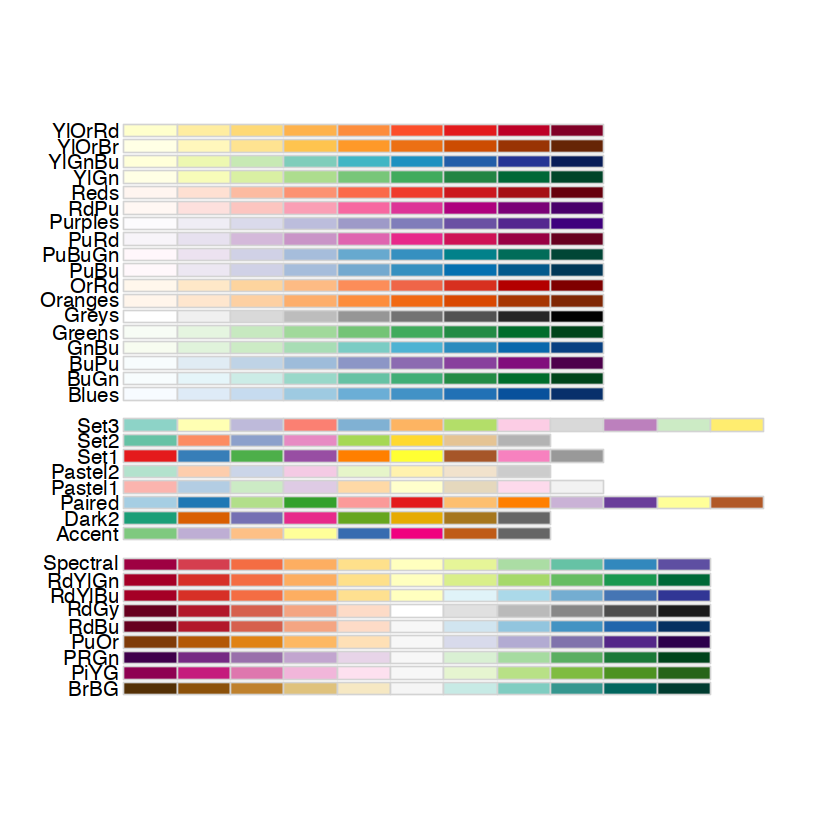

In [102]:
RColorBrewer::display.brewer.all(colorblindFriendly = F)  

In [103]:
patients_cycles$cycle <- as.numeric(patients_cycles$cycle)

In [104]:
mydat_m$cycle <- as.numeric(mydat_m$cycle)

In [105]:
head(patients_cycles)

,Patient,cycle,cancergroup,Disease_type,Age
,<fct>,<dbl>,<chr>,<chr>,<dbl>
1,CHP_346,5,Solid,NB,1
2,CHP_347,5,Leukemia,ALL,13
3,CHP_348,5,Solid,OS,18
4,CHP_349,5,Leukemia,CML,17
5,CHP_350,5,Solid,HB,1
6,CHP_352,5,Leukemia,HR ALL,17


In [106]:
# recode cycle to 6, just for plotting
patients_cycles$cycle <- ifelse(patients_cycles$cycle == 5, 6, patients_cycles$cycle)

In [107]:
head(mydat_m)

,Var1,Var2,value,cycle,Datatype,cancergroup
,<fct>,<fct>,<dbl>,<dbl>,<chr>,<chr>
16,CHP_346,PBMC_1,1,1,PBMC,Solid
17,CHP_347,PBMC_1,13,1,PBMC,Leukemia
18,CHP_348,PBMC_1,18,1,PBMC,Solid
19,CHP_349,PBMC_1,17,1,PBMC,Leukemia
20,CHP_350,PBMC_1,1,1,PBMC,Solid
22,CHP_352,PBMC_1,17,1,PBMC,Leukemia


In [108]:
mydat_m$Var2 <- as.character(mydat_m$Var2)

In [109]:
mydat_m$Datatype[mydat_m$Datatype == "PBMC"] <- "CapTCR-seq(PBMC)"
mydat_m$Datatype[mydat_m$Datatype == "cfDNA"] <- "CapTCR-seq(cfDNA)"
mydat_m$Datatype[mydat_m$Datatype == "FOLD"] <- "ex vivo T-cell expansion"
mydat_m$Datatype[mydat_m$Datatype == "CD3"] <- "Flow cytometry"

In [110]:
mydat_m$newcycle <- NA

for(i in 1:5){
    mydat_m$newcycle[mydat_m$cycle == i & mydat_m$Datatype == "CapTCR-seq(PBMC)"] <- i-0.2
    mydat_m$newcycle[mydat_m$cycle == i & mydat_m$Datatype == "CapTCR-seq(cfDNA)"] <- i-0.1
    mydat_m$newcycle[mydat_m$cycle == i & mydat_m$Datatype == "ex vivo T-cell expansion"] <- i + 0.1
    mydat_m$newcycle[mydat_m$cycle == i & mydat_m$Datatype == "Flow cytometry"] <- i+ 0.2
}

In [111]:
head(mydat_m)

,Var1,Var2,value,cycle,Datatype,cancergroup,newcycle
,<fct>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
16,CHP_346,PBMC_1,1,1,CapTCR-seq(PBMC),Solid,0.8
17,CHP_347,PBMC_1,13,1,CapTCR-seq(PBMC),Leukemia,0.8
18,CHP_348,PBMC_1,18,1,CapTCR-seq(PBMC),Solid,0.8
19,CHP_349,PBMC_1,17,1,CapTCR-seq(PBMC),Leukemia,0.8
20,CHP_350,PBMC_1,1,1,CapTCR-seq(PBMC),Solid,0.8
22,CHP_352,PBMC_1,17,1,CapTCR-seq(PBMC),Leukemia,0.8


In [112]:
p0 <- ggplot( patients_cycles, aes(Patient, cycle)) +
  geom_bar(stat="identity", aes(fill=cancergroup), width=0.9, alpha = 0.2) +
  geom_point(data=mydat_m,aes(Var1, newcycle, colour = Datatype, shape=Datatype), size=2) +
  coord_flip() +
  scale_fill_manual(values= group_col[c("Leukemia", "Lymphoma", "Solid")]) +
  scale_color_brewer(palette = "Set1")+
  scale_shape_manual(values=c(15,16,17,18)) +
  scale_y_continuous(expand = c(0,0), limits = c(0,6), breaks = c(1,2,3,4,5)) +
  #labs(fill="Disease Stage", colour="", shape="", x="Subject Recevied Study Drug") +
  myplot +
  theme(axis.title.y = element_blank(), axis.text.y = element_text(size = 5), axis.ticks.x = element_blank(), plot.margin = unit(c(0.1, 0.2, 1, 0.2), "cm"),
  axis.line.x = element_line(colour = "black"), axis.text.x = element_text(size = 10)) 

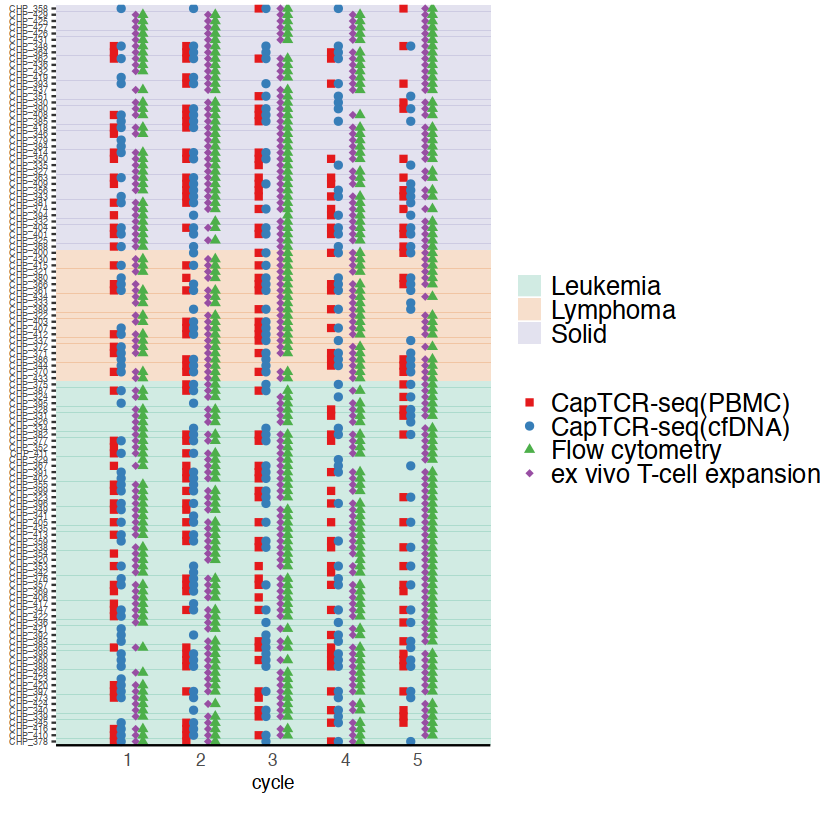

In [113]:
p0

In [114]:
pdf(paste0(plotpath,"test.pdf"), width=10, height=10)
p0
dev.off()

pdf 
  2

age barplot on the right

In [115]:
head(patients_cycles)

,Patient,cycle,cancergroup,Disease_type,Age
,<fct>,<dbl>,<chr>,<chr>,<dbl>
1,CHP_346,6,Solid,NB,1
2,CHP_347,6,Leukemia,ALL,13
3,CHP_348,6,Solid,OS,18
4,CHP_349,6,Leukemia,CML,17
5,CHP_350,6,Solid,HB,1
6,CHP_352,6,Leukemia,HR ALL,17


In [116]:
p1 <- ggplot( patients_cycles, aes(Patient, Age)) +
  geom_bar(stat="identity", aes(fill=cancergroup), width=0.8, alpha = 0.2) +
  #geom_text(aes(label=Disease_type),vjust = 0.5,hjust = -1, size = 2) +
  coord_flip() +
  scale_fill_manual(values= group_col[c("Leukemia", "Lymphoma", "Solid")]) +
  scale_color_brewer(palette = "Set1")+
  scale_shape_manual(values=c(15,16,17,18)) +
  scale_y_continuous(expand = c(0,0)) +
  #labs(fill="Disease Stage", colour="", shape="", x="Subject Recevied Study Drug") +
  myplot + theme(legend.position="none", plot.margin = unit(c(0.1, 0.2, 1, 0.2), "cm"),
  axis.text.y = element_blank(), axis.title.y = element_blank(),
  axis.line.x = element_line(colour = "black"))

In [117]:
patients_cycles[patients_cycles$Patient == "CHP_358", ]

,Patient,cycle,cancergroup,Disease_type,Age
,<fct>,<dbl>,<chr>,<chr>,<dbl>
76,CHP_358,6,Solid,WILMS,2


In [118]:
library(cowplot)

In [119]:
allp <- plot_grid(p0 + theme(legend.position = "none") +
scale_x_discrete(labels = patients_cycles$Disease_type[match(levels(patients_cycles$Patient), patients_cycles$Patient)]) +
labs(y = "Sample collection prior chemotherapy cycle"),
p1 + labs(y = "Age (Years)"), ncol = 2, rel_widths = c(1, 0.3))

In [120]:
allp_legends <- plot_grid(allp, get_legend(p0 + 
theme(legend.position = 'bottom', legend.box = 'vertical', legend.margin = margin(0,0,0,0)) +
guides(colour = guide_legend(override.aes = list(size=5), nrow = 2, byrow = T))), 
ncol = 1, rel_heights = c(1, 0.1))

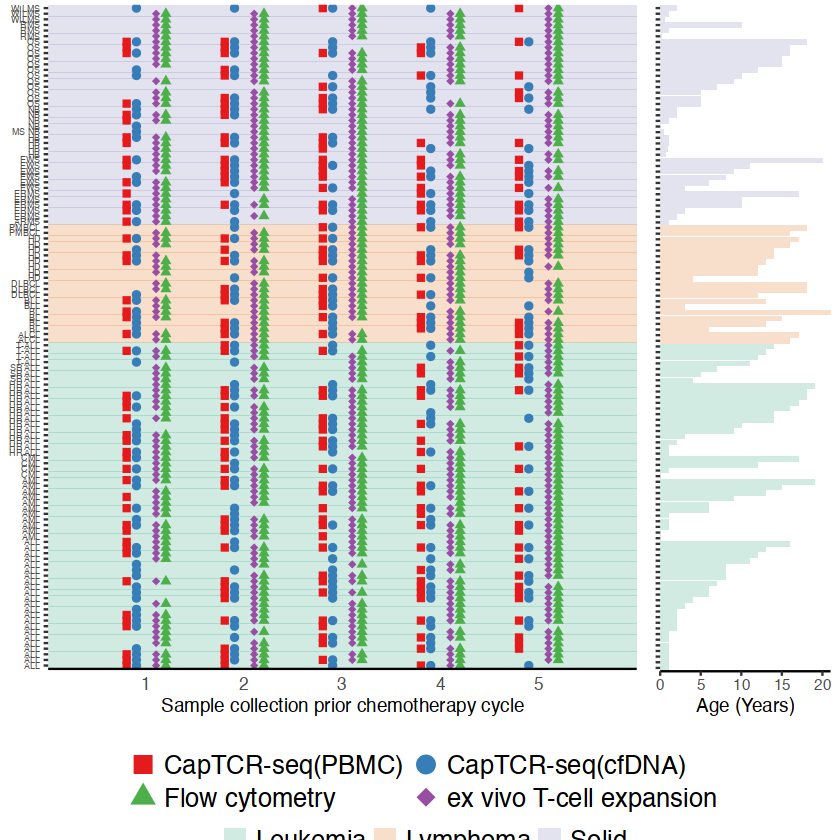

In [121]:
allp_legends

In [122]:
pdf(paste0(plotpath,"swimmerplot.pdf"), width=10, height=10)
allp_legends
dev.off()

pdf 
  2